# ripe or rotten mango?

In this section, we import the necessary libraries to handle file operations, numerical computations, data processing, visualization, and image handling.

In [1]:
# Reload modules before executing cells and set working directory
%reload_ext autoreload
%autoreload 2

import sys 
sys.path.append('../')

In [8]:
# Import required packages
import os  # For working with file paths
import cv2  # For image processing
import numpy as np  # For linear algebra operations
import pandas as pd  # For data processing and manipulation
import matplotlib.pyplot as plt  # For data visualization
from PIL import Image  # For loading image data
from random import sample  # For random sampling
from src import CSVData, MangoDataset, MangoProcessor  # For loading dataset and image processing

Here, we initialize the MangoDataset and create a DataFrame that contains the image labels and filenames.

In [ ]:
# Define the path and train and validation sets
dataset = MangoDataset()

train_set = dataset.train_data
validation_set = dataset.validation_data

image_df = pd.DataFrame(train_set, columns=["label", "filename"])
print(image_df)

       label              filename
0       Ripe                 1.jpg
1       Ripe                10.jpg
2       Ripe              1000.jpg
3       Ripe               102.jpg
4       Ripe               103.jpg
...      ...                   ...
1984  Rotten  rottenMango (95).jpg
1985  Rotten  rottenMango (96).jpg
1986  Rotten  rottenMango (97).jpg
1987  Rotten  rottenMango (98).jpg
1988  Rotten  rottenMango (99).jpg

[1989 rows x 2 columns]


In [ ]:
# Create the image manager and process the images
processor = MangoProcessor(train_set)

processed_images = processor.get_processed_data()
features_df = pd.DataFrame(processed_images)
print(features_df)

      label  0    1    2    3   4    5    6    7   8  ...  4854  4855  4856  \
0         1  0   40  114  121  51   10    7    6   4  ...     0     1     0   
1         1  0  133   82   17  11    9    7    5   6  ...     0     0     0   
2         1  0   52   29   25  28    7    2    7   7  ...     0     0     0   
3         1  0    8    1    1  40  133  229  198  81  ...     0     0     0   
4         1  0    5    5    4   2    0    1    2   3  ...     0     0     0   
...     ... ..  ...  ...  ...  ..  ...  ...  ...  ..  ...   ...   ...   ...   
1984      0  0  237  203   60  23    1   29    9  20  ...     0     0     0   
1985      0  0   17   22   22  42   39   34   35   8  ...     0     0     0   
1986      0  0   16    4   39  25   14   29   12  12  ...     0     0     0   
1987      0  0   18    6    9  10   41   23   19  11  ...     0     0     0   
1988      0  0   20   10   35   2   37   21   18  10  ...     0     0     0   

      4857  4858  4859  4860  4861  4862  4863  
0 

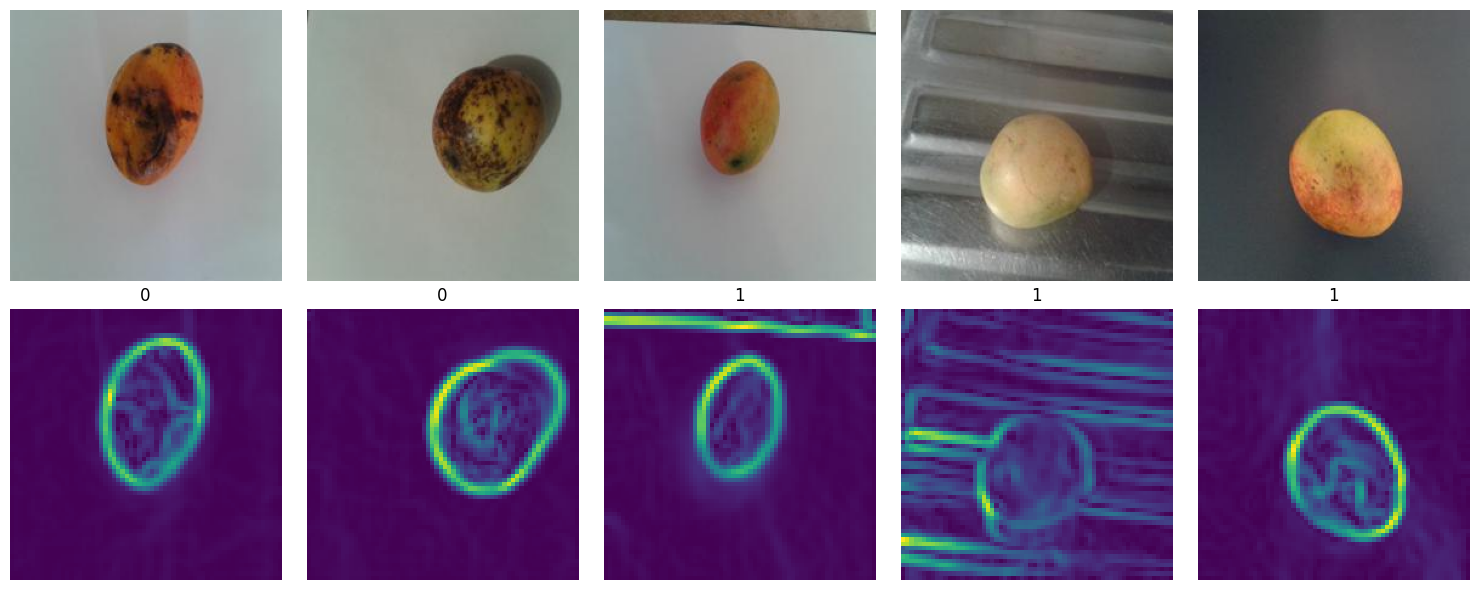

In [41]:
# Function to show sample images
def show_samples(processed_images, train_set, num_samples=5):
    num_samples = min(num_samples, len(processed_images))

    indices = sample(range(len(processed_images)), num_samples)
    selected_images = [(train_set[i], processed_images[i]) for i in indices]

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for ax, (orig_img, proc_img) in zip(axes[0], selected_images):
        ax.imshow(processor.load_original("train", orig_img))
        ax.axis("off")

    for ax, (orig_img, proc_img) in zip(axes[1], selected_images):
        ax.set_title(proc_img["label"])
        ax.imshow(processor.load_processed(proc_img))
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_samples(processed_images, train_set)